In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt

from helpers import *
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2

In [2]:
try: 
    import cv2
except: 
    import pip
    pip.main(['install', 'opencv-python'])
    import cv2 

In [39]:
# Load training images
root_dir = "training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

files = os.listdir(image_dir)

n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

print("Loading " + str(n) + " satellite + ground truth images")

Loading 100 satellite + ground truth images


In [44]:
# 
# Preparation training data
# 

# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size, step = 4) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size, step = 4) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Extract features
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
print(X.shape)

# Features augmentation 
X = features_augmentation(X)
# print(X.shape)
# print(X.ptp())

# # Standardize data
# X -= np.mean(X)
# X /= np.std(X)
# X = normalize_features(X)
# print(X.ptp())

print('Computed ' + str(X.shape[1]) + ' features for ' + str(X.shape[0]) + ' patches')

(1000000, 12)
Computed 91 features for 1000000 patches


In [45]:
# 
# Run logistic regression 
# 
y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

# 
# Balancing train data
# 
c0, c1 = 0, 0
for i in range(len(y)):
    if y[i] == 0:
        c0 = c0 + 1
    else:
        c1 = c1 + 1

min_c = min(c0, c1)
idx0 = [i for i, j in enumerate(y) if j == 0]
idx1 = [i for i, j in enumerate(y) if j == 1]
new_indices = idx0[0:min_c] + idx1[0:min_c]
X = X[new_indices]
y = y[new_indices]

print(len(y))

lambdas = np.logspace(-5, 0, 8)
Cs = [np.ceil(1/lambda_) for lambda_ in lambdas]
C_opt = Cs[0]

logreg = linear_model.LogisticRegression(C = C_opt, class_weight="balanced")
logreg.fit(X, y)
print("Model fitted!")

512760
Model fitted!


In [71]:
# 
# Preparation testing data
# 
root_testdir = "test_set_images"
test_names = os.listdir(root_testdir)

prefixes = ('.')
for dir_ in test_names[:]:
    if dir_.startswith(prefixes):
        test_names.remove(dir_)

# Get permutation to get test data in correct order
num_test = len(test_names)
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
p = np.argsort(order)

# Load data and reorder them
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]
imgs_test = [imgs_test[i] for i in p]

# Crop images in patch and Linearize list of patches
img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size, step = 16) for i in range(num_test)]
X_eval = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))]) 

# Extract, augment & standardize features
X_eval = np.asarray([ extract_features(X_eval[i]) for i in range(len(X_eval))])
X_eval = features_augmentation(X_eval)
# X_eval -= np.mean(X_eval)
# X_eval /= np.std(X_eval)
# X_eval = normalize_features(X_eval)
print("Ready to predict!")

# 
# Prediction testing data
# 
Z_eval = logreg.predict(X_eval)
print("Prediction done!")


# 
# Save prediction
# 
create_submission(Z_eval, "submission_LogReg.csv")



# 
# Post processing on eval dataset
# 

# Reshape prediction as matrix for each image
z_reshaped = []
z_reshaped_pp = []

num_patch_total = len(Z_eval)
num_patch_by_img = num_patch_total // num_test

for i in range(0, num_patch_total, num_patch_by_img):
    z_crt = Z_eval[i : i + num_patch_by_img]
    z_crt_reshaped = np.reshape(z_crt, [608 // 16, 608 // 16])
    z_reshaped.append(z_crt_reshaped)
    z_reshaped_pp.append(np.reshape(postprocess(z_crt_reshaped), z_crt.shape[0]))

# # Run post process
# zzz = z_reshaped
# for ind, label_img in enumerate(z_reshaped):
#     label_img_pp = postprocess(label_img)
#     zzz[ind] = np.reshape(label_img_pp, [z_crt.shape[0]])

# Convert list as array
Z_eval_pp = np.concatenate( z_reshaped_pp , axis = 0 )
print("Postprocessing done!")

# 
# Save prediction
# 
create_submission(Z_eval_pp, "submission_LogReg_pp.csv")

Ready to predict!
Prediction done!
Postprocessing done!


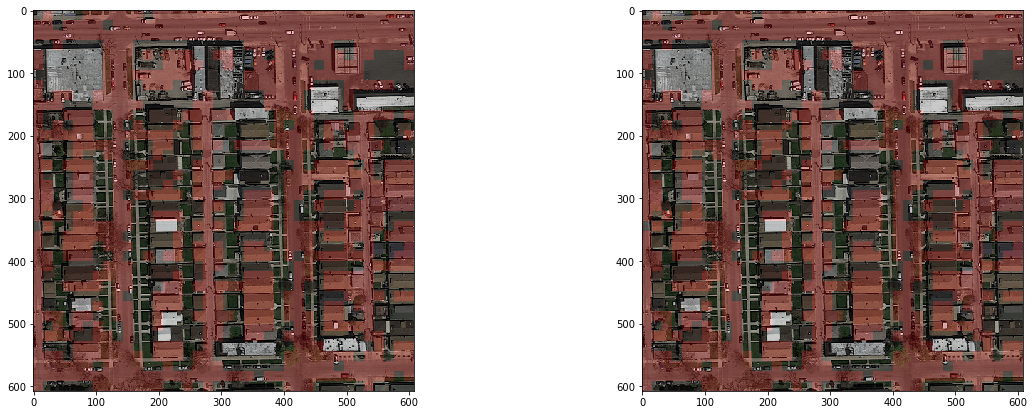

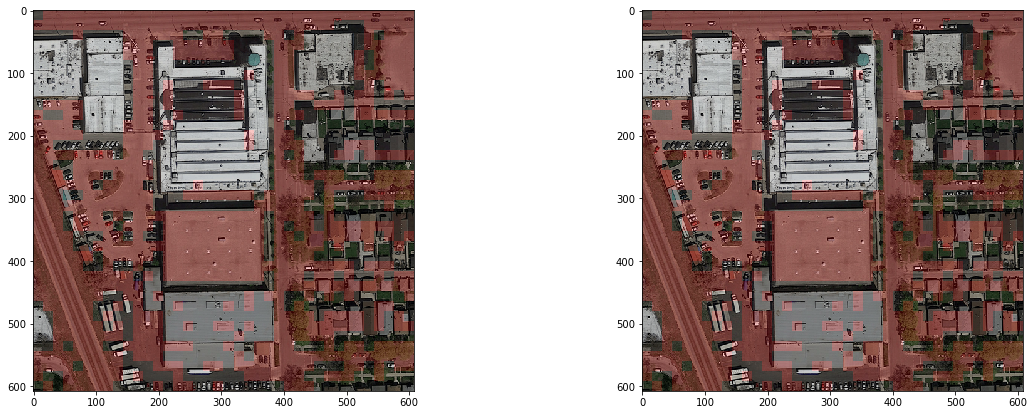

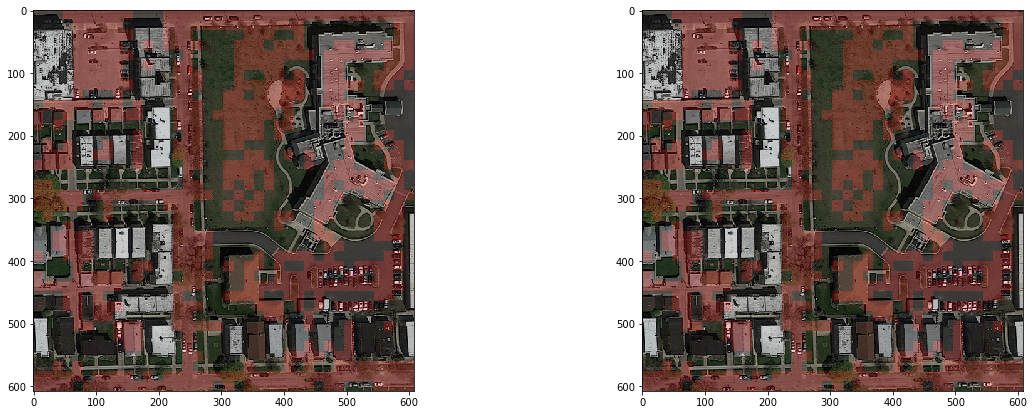

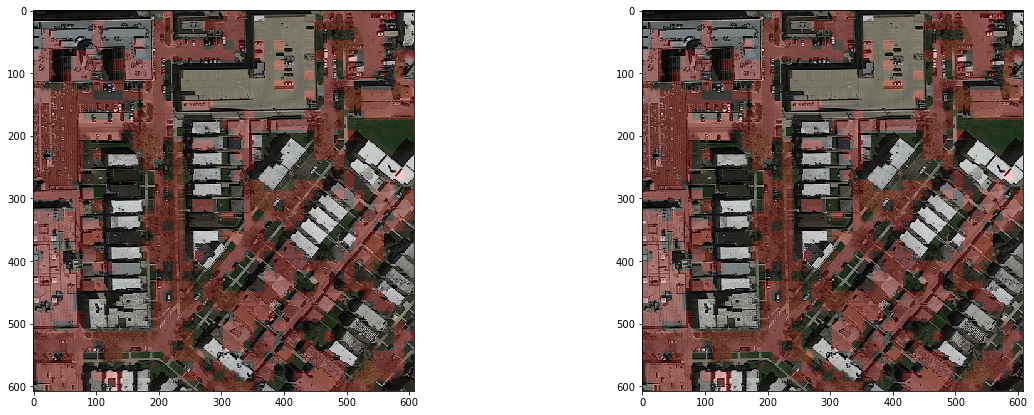

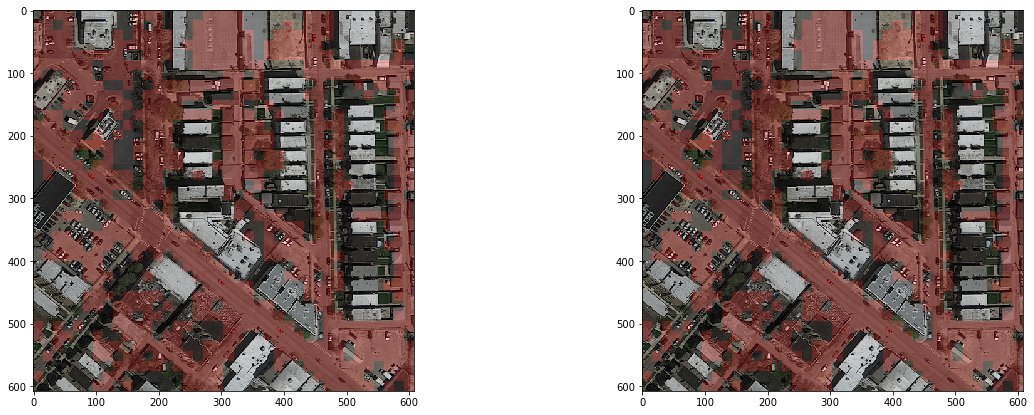

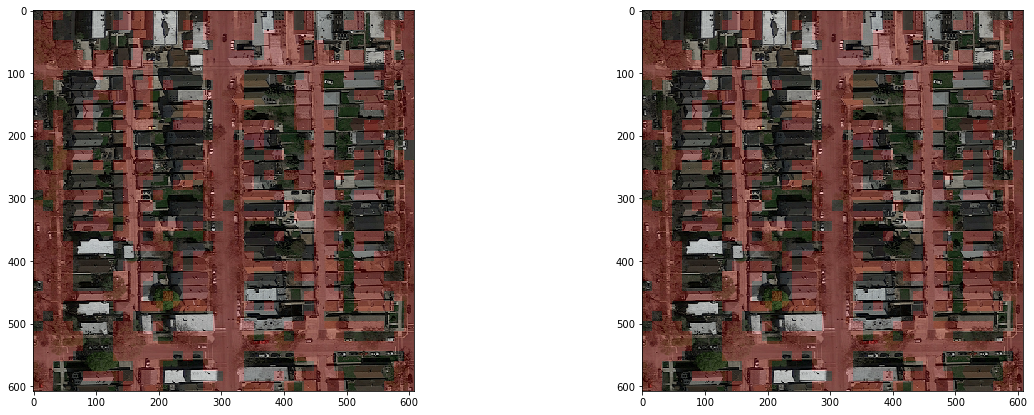

In [75]:
for img_idx in range(6):

    w = imgs_test[img_idx].shape[0]
    h = imgs_test[img_idx].shape[1]
    patch_size = 16

    fig1, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(20,7)) 
    pred = z_reshaped[img_idx]
    pred_img = label_to_img(w, h, patch_size, patch_size, np.reshape(pred, w // 16 * (h//16)))
    new_img = make_img_overlay(imgs_test[img_idx], pred_img)
    ax1.imshow(new_img)

    pred_pp = z_reshaped_pp[img_idx]
    pred_img = label_to_img(w, h, patch_size, patch_size, pred_pp)
    new_img = make_img_overlay(imgs_test[img_idx], pred_img)
    ax2.imshow(new_img)


In [73]:
pred.shape

(38, 38)